In [149]:
import tensorflow as tf
import pickle
import numpy as np
import random
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate, Card, Deck

import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

In [150]:
with open('../cache/maping.pkl', 'rb') as f:
    data = pickle.load(f)

In [152]:
len(data)

174196

In [153]:
suits = list(Card.SUIT_MAP.keys())
ranks = list(Card.RANK_MAP.keys())

def gen_card_im(card):
    a = np.zeros((4, 13))
    s = suits.index(card.suit)
    r = ranks.index(card.rank)
    a[s, r] = 1
    return np.pad(a, ((6, 7), (2, 2)), 'constant', constant_values=0)

def process_img(img):
    return np.reshape(img, [17 * 17 * 1])

def img_from_cards(cards):
    imgs = np.zeros((len(cards), 17, 17))
    for i, c in enumerate(cards):
        imgs[i] = gen_card_im(Card.from_str(c))
    return imgs.sum(axis=0)

def get_triple(cards):
    if len(cards) == 2:
        my = img_from_cards(cards)
        com = np.zeros((17, 17))
        un = my.copy()
    else:
        my = img_from_cards(cards[:2])
        com = img_from_cards(cards[2:])
        un = img_from_cards(cards)
    return my, com, un

## Example

In [154]:
a, b, c = get_triple(data[2][0])

### My hand

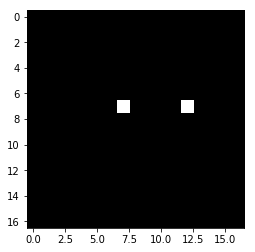

In [155]:
plt.imshow(a)
plt.gray()

### Community hand

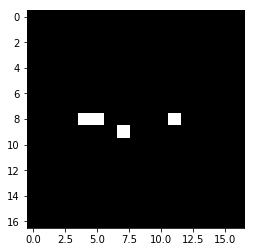

In [156]:
plt.imshow(b)

### Sum hand

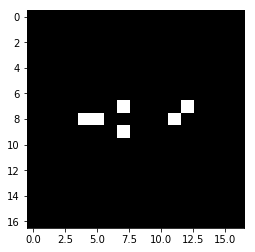

In [157]:
plt.imshow(c)

## Network

Three input for each image of hand. Output - win rate probability. Before output - three embeddings of each handm

In [158]:
class ConvNet():
    def __init__(self, embedding_size=32):
        self.embedding_size = embedding_size
        self.trainer = tf.train.AdamOptimizer()
        
        self.y = tf.placeholder(tf.float32, [None, 1])
        
        self.input1 = tf.placeholder(tf.float32, [None, 17, 17, 1])
        self.input2 = tf.placeholder(tf.float32, [None, 17, 17, 1])
        self.input3 = tf.placeholder(tf.float32, [None, 17, 17, 1])

        xavier_init = tf.contrib.layers.xavier_initializer()

        self.conv1_i1 = tf.layers.conv2d(self.input1, 64, 5, 2, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=None, name='conv1')
        self.conv1_i2 = tf.layers.conv2d(self.input2, 64, 5, 2, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=True, name='conv1')
        self.conv1_i3 = tf.layers.conv2d(self.input3, 64, 5, 2, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=True, name='conv1')
        
        self.conv2_i1 = tf.layers.conv2d(self.conv1_i1, 32, 3, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=None, name='conv2')
        self.conv2_i2 = tf.layers.conv2d(self.conv1_i2, 32, 3, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=True, name='conv2')
        self.conv2_i3 = tf.layers.conv2d(self.conv1_i3, 32, 3, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=True, name='conv2')
        
        self.conv3_i1 = tf.layers.conv2d(self.conv2_i1, self.embedding_size, 5, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=None, name='conv3')
        self.conv3_i2 = tf.layers.conv2d(self.conv2_i2, self.embedding_size, 5, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=True, name='conv3')
        self.conv3_i3 = tf.layers.conv2d(self.conv2_i3, self.embedding_size, 5, activation=tf.nn.elu,
                                      kernel_initializer=xavier_init, reuse=True, name='conv3')
        
        self.conv3_flat_i1 = tf.contrib.layers.flatten(self.conv3_i1)
        self.conv3_flat_i2 = tf.contrib.layers.flatten(self.conv3_i2)
        self.conv3_flat_i3 = tf.contrib.layers.flatten(self.conv3_i3)
        
        self.merge = tf.concat([self.conv3_flat_i1, self.conv3_flat_i2, self.conv3_flat_i3], axis=1)
        self.out = tf.layers.dense(self.merge, 1, activation=tf.nn.sigmoid, kernel_initializer=xavier_init)
        self.cross_entropy = tf.reduce_mean(-self.y * tf.log(tf.maximum(self.out, 0.00001))
                                            - (1 - self.y) * tf.log(tf.maximum(1 - self.out, 0.00001)))  
        self.update = self.trainer.minimize(self.cross_entropy)
        self.mae = tf.reduce_mean(tf.abs(tf.subtract(self.out, self.y)))
        
        variables = tf.trainable_variables()
        self.var_norms = tf.global_norm(variables)
        self.summary_writer = tf.summary.FileWriter('../log/ConvNet/')

## Split on train/test (95/5)

In [162]:
len(data) // 40

4354

In [163]:
test, data = data[:len(data) // 40], data[len(data) // 40:]

In [164]:
len(test), len(data)

(4354, 169842)

In [ ]:
%%time
tf.reset_default_graph()
load_model = True

net = ConvNet()
saver = tf.train.Saver(max_to_keep=3)

init = tf.global_variables_initializer()
trainables = tf.trainable_variables()

path = '../cache/models/ConvNet/'
epoch = 30
batch_size = 128


with tf.Session() as sess:
    sess.run(init)
    if load_model:
        print('Loading model')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    global_step = 0
    for i in range(epoch):
        random.shuffle(data)
        for j in range(len(data) // batch_size):
            batch = data[j * batch_size: (j + 1) * batch_size]
            mys, coms, uns, ys = [], [], [], []
            for k in range(len(batch)):
                my, com, un = get_triple(batch[k][0])
                mys.append(np.expand_dims(np.expand_dims(my, 0), -1))
                coms.append(np.expand_dims(np.expand_dims(com, 0), -1))
                uns.append(np.expand_dims(np.expand_dims(un, 0), -1))
                ys.append(batch[k][1])
            mys = np.vstack(mys)
            coms = np.vstack(coms)
            uns = np.vstack(uns)
            ys = np.array(ys).reshape(-1, 1)
            
            feed_dict = {
                net.input1: mys,
                net.input2: coms,
                net.input3: uns,
                net.y: ys
            }
#             _ = sess.run([net.update], feed_dict=feed_dict)
            ce, mae, vn, pr, _ = sess.run([net.cross_entropy, net.mae, net.var_norms, net.out,
                                           net.update], feed_dict=feed_dict)
            if global_step % 20 == 0:
                summary = tf.Summary()
                summary.value.add(tag='Loss/Cross_Enropy', simple_value=ce)
                summary.value.add(tag='Loss/MAE', simple_value=mae)
                summary.value.add(tag='Loss/Var_Norm', simple_value=vn)
                summary.value.add(tag='Prediction/Pred', simple_value=pr[0, 0])
                summary.value.add(tag='Prediction/True', simple_value=ys[0, 0])
                
                if global_step % 100 == 0:
                    mys, coms, uns, ys = [], [], [], []
                    for k in range(len(test)):
                        my, com, un = get_triple(test[k][0])
                        mys.append(np.expand_dims(np.expand_dims(my, 0), -1))
                        coms.append(np.expand_dims(np.expand_dims(com, 0), -1))
                        uns.append(np.expand_dims(np.expand_dims(un, 0), -1))
                        ys.append(test[k][1])
                    mys = np.vstack(mys)
                    coms = np.vstack(coms)
                    uns = np.vstack(uns)
                    ys = np.array(ys).reshape(-1, 1)

                    feed_dict = {
                        net.input1: mys,
                        net.input2: coms,
                        net.input3: uns,
                        net.y: ys
                    }
                    
                    ce, mae = sess.run([net.cross_entropy, net.mae], feed_dict=feed_dict)
                    summary.value.add(tag='Validation/Cross_Enropy', simple_value=ce)
                    summary.value.add(tag='Validation/MAE', simple_value=mae)

                net.summary_writer.add_summary(summary, global_step)
                net.summary_writer.flush()
                
            global_step += 1
        saver.save(sess, path, global_step)
        print('Epoch {} end, model saved, steps: {}'.format(i, global_step))

## Number of total params

In [17]:
vars_ = tf.trainable_variables()
total_parameters = 0
for variable in vars_:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parameters = 1
    for dim in shape:
        print(dim)
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

(5, 5, 1, 64)
4
5
5
1
64
1600
(64,)
1
64
64
(3, 3, 64, 32)
4
3
3
64
32
18432
(32,)
1
32
32
(5, 5, 32, 32)
4
5
5
32
32
25600
(32,)
1
32
32
(96, 1)
2
96
1
96
(1,)
1
1
1
45857


## Evaluation time

In [18]:
%%time
tf.reset_default_graph()
net = ConvNet()
saver = tf.train.Saver()

CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 526 ms


In [26]:
mys = np.vstack(mys)

In [28]:
%%time
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    print(ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    flat_1 = sess.run(net.conv3_flat_i1, feed_dict={net.input1: mys})

../cache/models/ConvNet/-8096
INFO:tensorflow:Restoring parameters from ../cache/models/ConvNet/-8096
CPU times: user 128 ms, sys: 40 ms, total: 168 ms
Wall time: 161 ms


In [29]:
flat_1.shape

(94, 32)

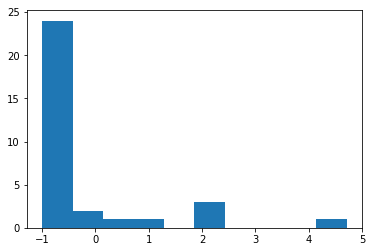

In [34]:
plt.hist(flat_1[4]);

## Predict on log data

In [52]:
import pandas as pd

In [60]:
df = pd.read_csv('../../../../Downloads/table1_17.csv.zip', header=None)

In [63]:
df.shape

(1074967, 15)

In [67]:
cards = df.iloc[:, 8:].values

In [69]:
n = df.shape[0] // 128
n

8398

In [110]:
%%time
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    print(ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    a_all, b_all, c_all, win_rate_all = None, None, None, None
    
    for i in range(n):
        if i == n - 1:
            batch = cards[i * 128:]
        else:
            batch = cards[i * 128: (i + 1) * 128]
        
        if i % 500 == 0:
            print(i)
        
        mys, coms, uns, ys = [], [], [], []
        for k in range(len(batch)):
            b = [x for x in batch[k] if x is not np.nan]
            my, com, un = get_triple(b)
            mys.append(np.expand_dims(np.expand_dims(my, 0), -1))
            coms.append(np.expand_dims(np.expand_dims(com, 0), -1))
            uns.append(np.expand_dims(np.expand_dims(un, 0), -1))
        mys = np.vstack(mys)
        coms = np.vstack(coms)
        uns = np.vstack(uns)
        
        feed_dict = {
            net.input1: mys,
            net.input2: coms,
            net.input3: uns
        }
        a, b, c, win_rate = sess.run([net.conv3_flat_i1, net.conv3_flat_i2, net.conv3_flat_i3,
                                      net.out], feed_dict=feed_dict)  
        if a_all is not None:
            a_all = np.vstack((a_all, a))
            b_all = np.vstack((b_all, b))
            c_all = np.vstack((c_all, c))
            win_rate_all = np.vstack((win_rate_all, win_rate))
        else:
            a_all = a
            b_all = b
            c_all = c
            win_rate_all = win_rate

../cache/models/ConvNet/-8096
INFO:tensorflow:Restoring parameters from ../cache/models/ConvNet/-8096
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
CPU times: user 30min 26s, sys: 34.6 s, total: 31min 1s
Wall time: 22min 46s


In [113]:
features = np.hstack((a_all, b_all, c_all, win_rate_all))

In [ ]:
with open('../cache/features.pkl', 'wb') as f:
    pickle.dump(features, f)